In [1]:
#We load in the specific data needed
import polars as pl
import numpy as np
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score

# data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_tech_nonscaled.parquet')
# datat = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_nonscaled.parquet')

# prc_filter = 0.125

# data = data[data['prc_option'] > prc_filter]
# datat = datat[datat['prc_option'] > prc_filter]

data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_val_tech_standardized_filter.parquet')
datat = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_scaled_all_sso_filter.parquet')

impl_volatility = 'impl_volatility_h_1_step'

test_data = datat[datat['date'] >= '2021-01-01']
total_train = data[data['date'] < '2021-01-01']

# data_sso = data_sso[data_sso['prc_option'] > prc_filter]
# datat_sso = datat_sso[datat_sso['prc_option'] > prc_filter]

basic = ['moneyness', 'T']
option_specific = ['cp_flag', 'spread_option', 'volume', 'prc_option', 'previous_iv']
macro_features = ['2Y_bond','FF_rate', 'gold_price','reces_indi', 'CLOSE_vix', 'hi-lo_vix']
stock_specific = ['BID', 'ASK', 'daily_return_indicator_stock', 'hi-lo_stock', 'PRC', "vol_stock", 'RET', 'spread_stock']

tickers = ['ticker_AAPL', 'ticker_AMZN', 'ticker_META', 'ticker_MSFT','ticker_NVDA', 'ticker_TSLA'  ]


totalList = ['moneyness', 'T'] + macro_features + option_specific + stock_specific + tickers

totalList_standardize = totalList + ['impl_volatility', 'date', 'ticker']

In [2]:
data

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,total_iv_weighted,previous_iv,previous_iv_all,ticker_AAPL,ticker_AMZN,ticker_META,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker
591,2019-01-02,1,1547500,16.10,16.65,320,49,0.443137,0.442447,0.007817,...,2322.037880,0.464040,0.481556,0,1,0,0,0,0,AMZN
592,2019-01-02,1,1550000,15.05,15.60,7050,2131,0.443124,0.423105,0.007753,...,47875.670865,0.464040,0.481556,0,1,0,0,0,0,AMZN
593,2019-01-02,1,1552500,14.05,14.55,411,117,0.442606,0.403853,0.007679,...,2601.328244,0.464040,0.481556,0,1,0,0,0,0,AMZN
594,2019-01-02,1,1555000,13.10,13.60,635,153,0.442704,0.384996,0.007577,...,3752.912484,0.464040,0.481556,0,1,0,0,0,0,AMZN
595,2019-01-02,1,1557500,12.20,12.70,218,87,0.442872,0.366466,0.007457,...,1201.998895,0.464040,0.481556,0,1,0,0,0,0,AMZN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258424,2020-12-31,0,210000,0.30,0.31,2845,2301,0.273027,-0.074618,0.015690,...,236.912354,0.228589,0.414074,0,0,0,1,0,0,MSFT
258425,2020-12-31,0,212500,0.44,0.45,1770,1626,0.253881,-0.108790,0.022318,...,199.969370,0.228589,0.414074,0,0,0,1,0,0,MSFT
258427,2020-12-31,0,215000,0.68,0.70,2446,2313,0.238284,-0.163603,0.031463,...,402.161438,0.228589,0.414074,0,0,0,1,0,0,MSFT
258428,2020-12-31,0,207500,0.21,0.22,2470,1835,0.292736,-0.052148,0.011070,...,155.457453,0.228589,0.414074,0,0,0,1,0,0,MSFT


In [19]:
totalList

['T', 'moneyness', 'previous_iv', 'ticker_TSLA', 'cp_flag']

Training data feature names: ['const', 'moneyness', 'T', '2Y_bond', 'FF_rate', 'gold_price', 'reces_indi', 'CLOSE_vix', 'hi-lo_vix', 'cp_flag', 'spread_option', 'volume', 'prc_option', 'previous_iv', 'BID', 'ASK', 'daily_return_indicator_stock', 'hi-lo_stock', 'PRC', 'vol_stock', 'RET', 'spread_stock', 'ticker_AAPL', 'ticker_AMZN', 'ticker_META', 'ticker_MSFT', 'ticker_NVDA', 'ticker_TSLA', 'moneyness_squared', 'T_squared', '2Y_bond_squared', 'FF_rate_squared', 'gold_price_squared', 'reces_indi_squared', 'CLOSE_vix_squared', 'hi-lo_vix_squared', 'cp_flag_squared', 'spread_option_squared', 'volume_squared', 'prc_option_squared', 'previous_iv_squared', 'BID_squared', 'ASK_squared', 'daily_return_indicator_stock_squared', 'hi-lo_stock_squared', 'PRC_squared', 'vol_stock_squared', 'RET_squared', 'spread_stock_squared', 'ticker_AAPL_squared', 'ticker_AMZN_squared', 'ticker_META_squared', 'ticker_MSFT_squared', 'ticker_NVDA_squared', 'ticker_TSLA_squared']
Training data shape: (172951, 55)
A

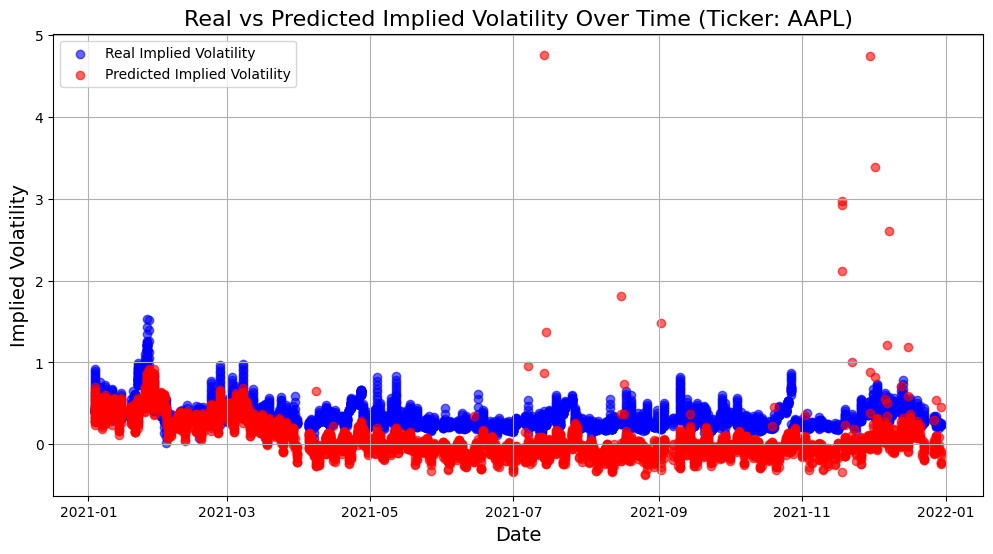

TICKER: AMZN
X_ticker feature names: ['const', 'moneyness', 'T', '2Y_bond', 'FF_rate', 'gold_price', 'reces_indi', 'CLOSE_vix', 'hi-lo_vix', 'cp_flag', 'spread_option', 'volume', 'prc_option', 'previous_iv', 'BID', 'ASK', 'daily_return_indicator_stock', 'hi-lo_stock', 'PRC', 'vol_stock', 'RET', 'spread_stock', 'ticker_AAPL', 'ticker_AMZN', 'ticker_META', 'ticker_MSFT', 'ticker_NVDA', 'ticker_TSLA', 'moneyness_squared', 'T_squared', '2Y_bond_squared', 'FF_rate_squared', 'gold_price_squared', 'reces_indi_squared', 'CLOSE_vix_squared', 'hi-lo_vix_squared', 'cp_flag_squared', 'spread_option_squared', 'volume_squared', 'prc_option_squared', 'previous_iv_squared', 'BID_squared', 'ASK_squared', 'daily_return_indicator_stock_squared', 'hi-lo_stock_squared', 'PRC_squared', 'vol_stock_squared', 'RET_squared', 'spread_stock_squared', 'ticker_AAPL_squared', 'ticker_AMZN_squared', 'ticker_META_squared', 'ticker_MSFT_squared', 'ticker_NVDA_squared', 'ticker_TSLA_squared']
X_ticker shape: (49431, 55)

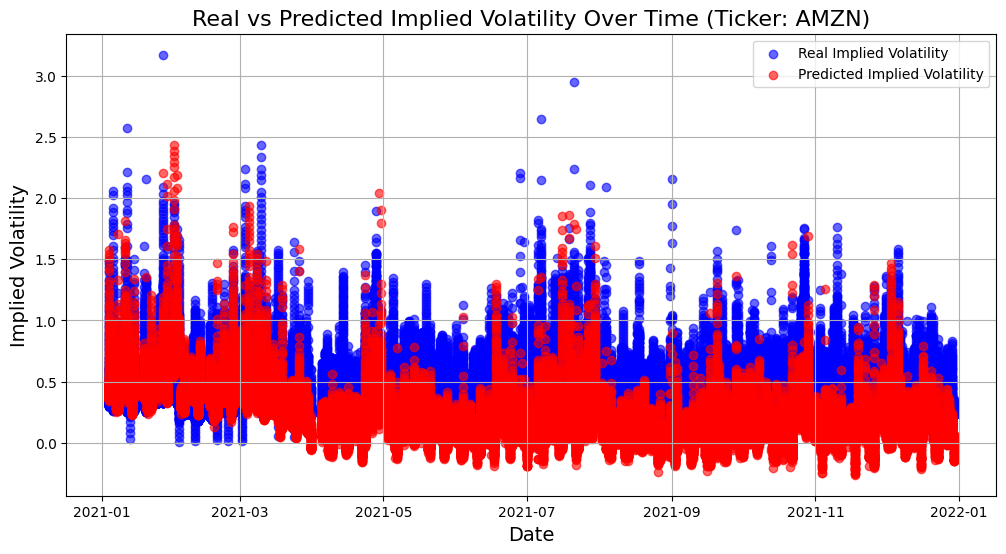

TICKER: META
X_ticker feature names: ['const', 'moneyness', 'T', '2Y_bond', 'FF_rate', 'gold_price', 'reces_indi', 'CLOSE_vix', 'hi-lo_vix', 'cp_flag', 'spread_option', 'volume', 'prc_option', 'previous_iv', 'BID', 'ASK', 'daily_return_indicator_stock', 'hi-lo_stock', 'PRC', 'vol_stock', 'RET', 'spread_stock', 'ticker_AAPL', 'ticker_AMZN', 'ticker_META', 'ticker_MSFT', 'ticker_NVDA', 'ticker_TSLA', 'moneyness_squared', 'T_squared', '2Y_bond_squared', 'FF_rate_squared', 'gold_price_squared', 'reces_indi_squared', 'CLOSE_vix_squared', 'hi-lo_vix_squared', 'cp_flag_squared', 'spread_option_squared', 'volume_squared', 'prc_option_squared', 'previous_iv_squared', 'BID_squared', 'ASK_squared', 'daily_return_indicator_stock_squared', 'hi-lo_stock_squared', 'PRC_squared', 'vol_stock_squared', 'RET_squared', 'spread_stock_squared', 'ticker_AAPL_squared', 'ticker_AMZN_squared', 'ticker_META_squared', 'ticker_MSFT_squared', 'ticker_NVDA_squared', 'ticker_TSLA_squared']
X_ticker shape: (6758, 55)


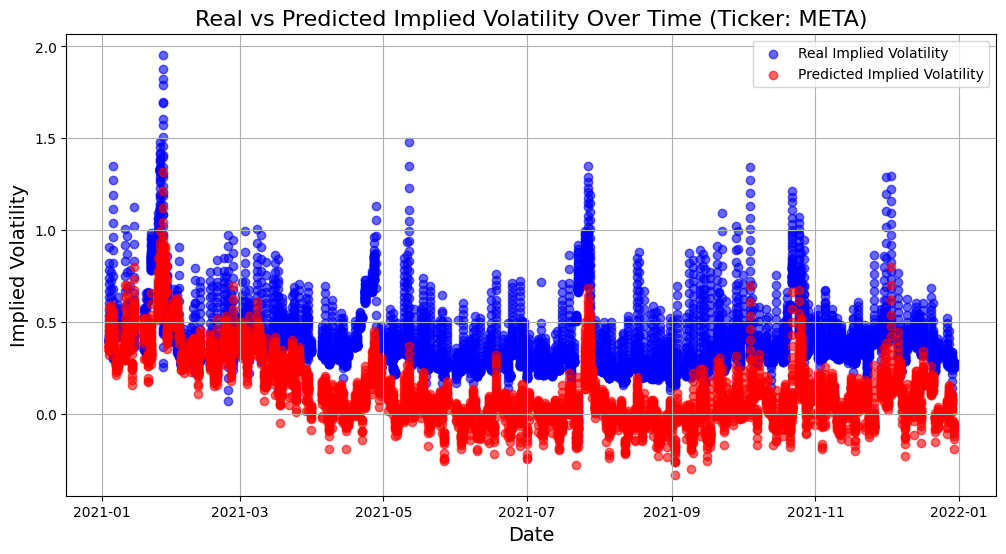

TICKER: MSFT
X_ticker feature names: ['const', 'moneyness', 'T', '2Y_bond', 'FF_rate', 'gold_price', 'reces_indi', 'CLOSE_vix', 'hi-lo_vix', 'cp_flag', 'spread_option', 'volume', 'prc_option', 'previous_iv', 'BID', 'ASK', 'daily_return_indicator_stock', 'hi-lo_stock', 'PRC', 'vol_stock', 'RET', 'spread_stock', 'ticker_AAPL', 'ticker_AMZN', 'ticker_META', 'ticker_MSFT', 'ticker_NVDA', 'ticker_TSLA', 'moneyness_squared', 'T_squared', '2Y_bond_squared', 'FF_rate_squared', 'gold_price_squared', 'reces_indi_squared', 'CLOSE_vix_squared', 'hi-lo_vix_squared', 'cp_flag_squared', 'spread_option_squared', 'volume_squared', 'prc_option_squared', 'previous_iv_squared', 'BID_squared', 'ASK_squared', 'daily_return_indicator_stock_squared', 'hi-lo_stock_squared', 'PRC_squared', 'vol_stock_squared', 'RET_squared', 'spread_stock_squared', 'ticker_AAPL_squared', 'ticker_AMZN_squared', 'ticker_META_squared', 'ticker_MSFT_squared', 'ticker_NVDA_squared', 'ticker_TSLA_squared']
X_ticker shape: (4087, 55)


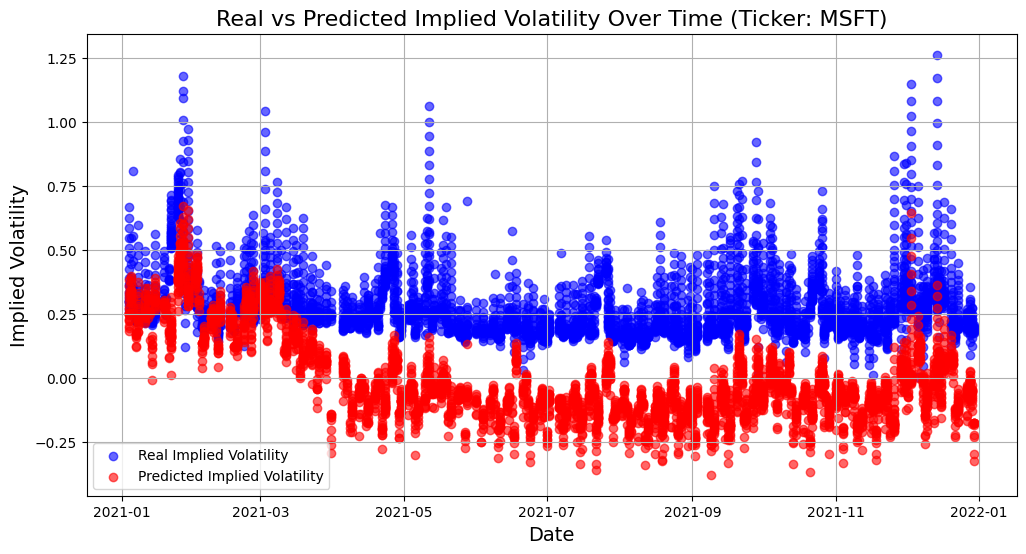

TICKER: NVDA
X_ticker feature names: ['const', 'moneyness', 'T', '2Y_bond', 'FF_rate', 'gold_price', 'reces_indi', 'CLOSE_vix', 'hi-lo_vix', 'cp_flag', 'spread_option', 'volume', 'prc_option', 'previous_iv', 'BID', 'ASK', 'daily_return_indicator_stock', 'hi-lo_stock', 'PRC', 'vol_stock', 'RET', 'spread_stock', 'ticker_AAPL', 'ticker_AMZN', 'ticker_META', 'ticker_MSFT', 'ticker_NVDA', 'ticker_TSLA', 'moneyness_squared', 'T_squared', '2Y_bond_squared', 'FF_rate_squared', 'gold_price_squared', 'reces_indi_squared', 'CLOSE_vix_squared', 'hi-lo_vix_squared', 'cp_flag_squared', 'spread_option_squared', 'volume_squared', 'prc_option_squared', 'previous_iv_squared', 'BID_squared', 'ASK_squared', 'daily_return_indicator_stock_squared', 'hi-lo_stock_squared', 'PRC_squared', 'vol_stock_squared', 'RET_squared', 'spread_stock_squared', 'ticker_AAPL_squared', 'ticker_AMZN_squared', 'ticker_META_squared', 'ticker_MSFT_squared', 'ticker_NVDA_squared', 'ticker_TSLA_squared']
X_ticker shape: (12728, 55)

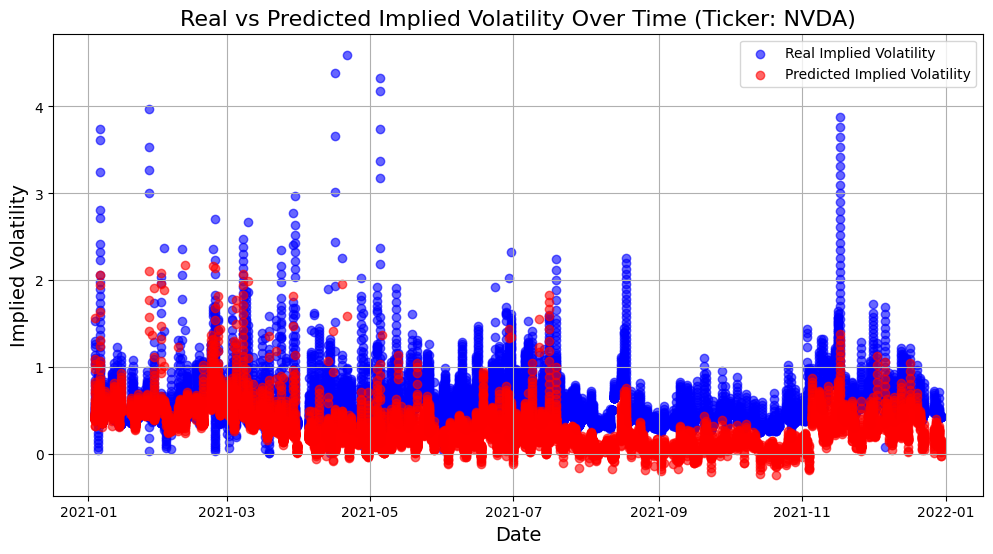

TICKER: TSLA
X_ticker feature names: ['const', 'moneyness', 'T', '2Y_bond', 'FF_rate', 'gold_price', 'reces_indi', 'CLOSE_vix', 'hi-lo_vix', 'cp_flag', 'spread_option', 'volume', 'prc_option', 'previous_iv', 'BID', 'ASK', 'daily_return_indicator_stock', 'hi-lo_stock', 'PRC', 'vol_stock', 'RET', 'spread_stock', 'ticker_AAPL', 'ticker_AMZN', 'ticker_META', 'ticker_MSFT', 'ticker_NVDA', 'ticker_TSLA', 'moneyness_squared', 'T_squared', '2Y_bond_squared', 'FF_rate_squared', 'gold_price_squared', 'reces_indi_squared', 'CLOSE_vix_squared', 'hi-lo_vix_squared', 'cp_flag_squared', 'spread_option_squared', 'volume_squared', 'prc_option_squared', 'previous_iv_squared', 'BID_squared', 'ASK_squared', 'daily_return_indicator_stock_squared', 'hi-lo_stock_squared', 'PRC_squared', 'vol_stock_squared', 'RET_squared', 'spread_stock_squared', 'ticker_AAPL_squared', 'ticker_AMZN_squared', 'ticker_META_squared', 'ticker_MSFT_squared', 'ticker_NVDA_squared', 'ticker_TSLA_squared']
X_ticker shape: (22942, 55)

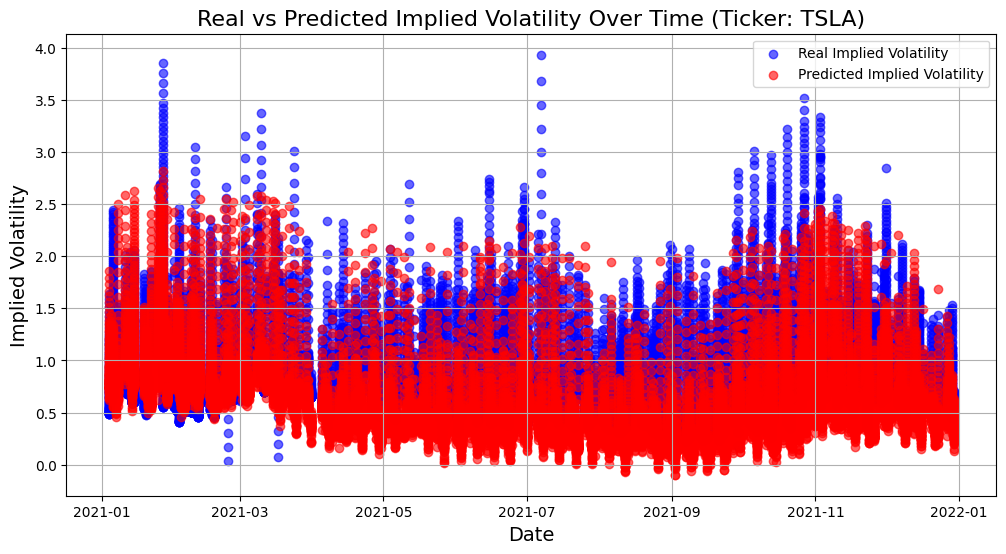

Overall Weighted RMSE: 0.3387190205714034
Overall Weighted R²: -0.7039627051175116
Top 10 Features (Feature, Importance):
ticker_AMZN            0.083333
ticker_AMZN_squared    0.083333
ticker_MSFT_squared    0.083333
ticker_MSFT            0.083333
ticker_AAPL            0.083333
ticker_AAPL_squared    0.083333
ticker_META_squared    0.083333
ticker_META            0.083333
ticker_NVDA            0.083333
ticker_NVDA_squared    0.083333
dtype: float64
Overall Weighted RMSE: 0.3387190205714034
Overall Weighted R²: -0.7039627051175116


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    
    Parameters:
    - errors: Array-like of prediction errors
    - lag: Maximum lag to use for the Newey-West estimator (default is 1)
    
    Returns:
    - Newey-West standard error of the prediction errors
    """
    X = np.ones(len(errors))  # Constant term for OLS
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    return ols_model.bse[0]  # Standard error of the constant term

def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time.
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

def run_ols_with_squares(train_data, test_data, totalList, title):
    """
    Runs OLS regression with squared terms only, calculates RMSE and R² for both
    in-sample (training) and out-of-sample (test) data, and returns the model and feature names.
    """
    # Prepare the training data
    y_train = train_data[impl_volatility]
    X_train = train_data[totalList].copy()

    # Add squared terms for each variable
    for feature in totalList:
        X_train[f"{feature}_squared"] = X_train[feature] ** 2

    # Add constant for intercept
    X_train = sm.add_constant(X_train)  # Add a constant for intercept

    # Debug: Print training feature names and shape
    print("Training data feature names:", X_train.columns.tolist())
    print("Training data shape:", X_train.shape)

    # Fit the OLS model on the training data
    model = sm.OLS(y_train, X_train).fit()

    # Predict on the in-sample (training) data
    y_train_pred = model.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)

    print(f'{title} In-sample RMSE: {rmse_train}')
    print(f'{title} In-sample R²: {r2_train}')

    # Prepare the test data
    y_test = test_data[impl_volatility]
    X_test = test_data[totalList].copy()

    # Add squared terms for each variable
    for feature in totalList:
        X_test[f"{feature}_squared"] = X_test[feature] ** 2

    # Add constant for intercept
    X_test = sm.add_constant(X_test)  # Add a constant for intercept

    # Debug: Print test feature names and shape
    print("Test data feature names:", X_test.columns.tolist())
    print("Test data shape:", X_test.shape)

    # Predict on the out-of-sample (test) data
    y_test_pred = model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)

    errors_test = y_test - y_test_pred
    test_data['Errors'] = errors_test  # Add errors to the test dataset

    # Group errors by date and calculate daily averages
    if 'date' in test_data.columns:
        daily_avg_errors = test_data.groupby('date')['Errors'].mean()
        print(f"Daily average errors calculated for {len(daily_avg_errors)} days.")
    else:
        raise ValueError("The dataset does not contain a 'date' column.")

    # Calculate Newey-West standard error using daily averages
    nw_std_error_test = newey_west_standard_error(daily_avg_errors.values, lag=1)
    print(f"Newey-West Standard Error (Based on Daily Averages): {nw_std_error_test}")

    # Save the daily errors and Newey-West standard error into a CSV
    file_path = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/glm_all.csv'

    # Create a DataFrame with daily averaged errors and repeated Newey-West standard error
    dm_test_data = pd.DataFrame({
        'Date': daily_avg_errors.index,
        'Daily Avg Errors': daily_avg_errors.values,
        'Newey-West Std Error': [nw_std_error_test] * len(daily_avg_errors)
    })

    # Save the DataFrame to a CSV
    dm_test_data.to_csv(file_path, index=False)
    print(f"Daily average errors and Newey-West statistics saved to {file_path}")

    print(f'{title} Out-of-sample RMSE: {rmse_test}')
    print(f'{title} Out-of-sample R²: {r2_test}')

    # Return the model, feature names, and out-of-sample metrics
    feature_names = X_train.columns.tolist()
    return model, feature_names


def calculate_weighted_metrics(datat, model, totalList):
    """
    Calculates weighted RMSE and R² for each ticker and overall across all tickers,
    considering squared terms for features and ensuring proper alignment of features.
    """
    results_list_all = []
    unique_tickers = datat['Ticker'].unique()

    total_rmse_weighted_sum = 0
    total_r2_weighted_sum = 0
    total_observations = 0

    for ticker in unique_tickers:
        # Filter data for current ticker and prepare for prediction
        data_ticker = datat[datat['Ticker'] == ticker]
        y_ticker_actual = data_ticker[impl_volatility]
        X_ticker = data_ticker[totalList].copy()

        # Add squared terms for each feature
        for feature in totalList:
            X_ticker[f"{feature}_squared"] = X_ticker[feature] ** 2

        # Manually add constant column if missing
        if 'const' not in X_ticker.columns:
            X_ticker.insert(0, 'const', 1.0)  # Add constant column manually

        # Debug: Check feature names and shapes
        print(f"TICKER: {ticker}")
        print("X_ticker feature names:", X_ticker.columns.tolist())
        print("X_ticker shape:", X_ticker.shape)
        print("Model params shape:", model.params.shape)

        # Predict and calculate RMSE and R² for the ticker
        y_ticker_pred = model.predict(X_ticker)
        rmse_ticker = np.sqrt(mean_squared_error(y_ticker_actual, y_ticker_pred))
        r2_ticker = r2_score(y_ticker_actual, y_ticker_pred)
        num_observations = len(y_ticker_actual)

        # Weighted summing for overall RMSE and R²
        total_rmse_weighted_sum += num_observations * rmse_ticker**2
        total_r2_weighted_sum += num_observations * r2_ticker
        total_observations += num_observations

        results_list_all.append({
            'Ticker': ticker,
            'RMSE': rmse_ticker,
            'R²': r2_ticker
        })

        print(f'{ticker} RMSE: {rmse_ticker}')
        print(f'{ticker} R²: {r2_ticker}')

        # Plot Real vs Predicted for the ticker
        plot_real_vs_predicted(data_ticker, y_ticker_actual, y_ticker_pred, f'Ticker: {ticker}')

    # Calculate overall weighted RMSE and R²
    overall_rmse = np.sqrt(total_rmse_weighted_sum / total_observations)
    overall_r2 = total_r2_weighted_sum / total_observations

    print(f'Overall Weighted RMSE: {overall_rmse}')
    print(f'Overall Weighted R²: {overall_r2}')

    return {
        'Ticker_Results': results_list_all,
        'Overall_RMSE': overall_rmse,
        'Overall_R²': overall_r2
    }


# Run OLS model for all data and calculate weighted metrics
model, feature_names = run_ols_with_squares(data,datat, totalList, "All Data")
weighted_metrics = calculate_weighted_metrics(datat, model, totalList)

# Print the top 10 features with importance values
print("Top 10 Features (Feature, Importance):")
coefs = model.params.drop('const')
importance = coefs.abs() / coefs.abs().sum()
top_10_features = importance.sort_values(ascending=False).head(10)
print(top_10_features)

# Print overall weighted RMSE and R²
print(f"Overall Weighted RMSE: {weighted_metrics['Overall_RMSE']}")
print(f"Overall Weighted R²: {weighted_metrics['Overall_R²']}")


In [14]:
feature_names

['const',
 'T',
 'moneyness',
 'previous_iv',
 'ticker_TSLA',
 'cp_flag',
 'T_squared',
 'moneyness_squared',
 'previous_iv_squared',
 'ticker_TSLA_squared',
 'cp_flag_squared']

In [17]:
index_features_list = top_10_features.index.to_list()
values_list = top_10_features.values.tolist()
print(values_list)


[0.3224149854844788, 0.10646777244407703, 0.10046524387711019, 0.100465243877109, 0.09571069965641367, 0.07654776137377534, 0.04680380928692877, 0.03616627131461661, 0.022405670746750043, 0.022405670746745474]


Baseline R² (OOS): 0.0936
Feature: moneyness, Baseline R²: 0.0936, Perturbed R²: -0.4952, Absolute Change: 0.5888
Feature: T, Baseline R²: 0.0936, Perturbed R²: 0.2974, Absolute Change: 0.2037
Feature: 2Y_bond, Baseline R²: 0.0936, Perturbed R²: 0.2159, Absolute Change: 0.1222
Feature: FF_rate, Baseline R²: 0.0936, Perturbed R²: 0.6158, Absolute Change: 0.5221
Feature: gold_price, Baseline R²: 0.0936, Perturbed R²: 0.1289, Absolute Change: 0.0352
Feature: reces_indi, Baseline R²: 0.0936, Perturbed R²: 0.6876, Absolute Change: 0.5939
Feature: CLOSE_vix, Baseline R²: 0.0936, Perturbed R²: 0.1989, Absolute Change: 0.1053
Feature: hi-lo_vix, Baseline R²: 0.0936, Perturbed R²: 0.0766, Absolute Change: 0.0170
Feature: cp_flag, Baseline R²: 0.0936, Perturbed R²: 0.1117, Absolute Change: 0.0181
Feature: spread_option, Baseline R²: 0.0936, Perturbed R²: 0.0912, Absolute Change: 0.0025
Feature: volume, Baseline R²: 0.0936, Perturbed R²: 0.1139, Absolute Change: 0.0202
Feature: prc_option, Baseli

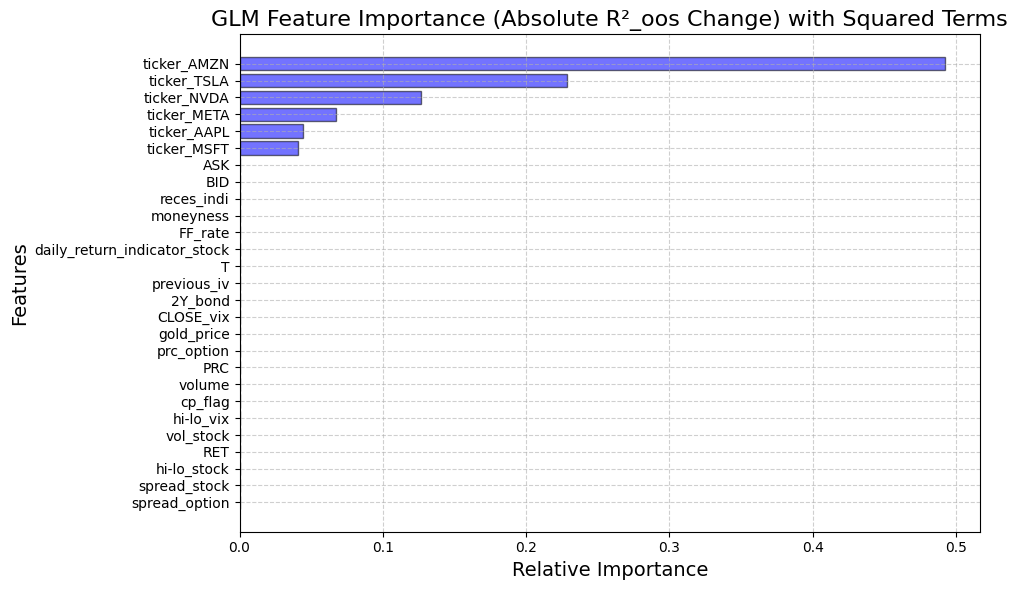

In [3]:
def calculate_feature_importance_r2_glm(data_test, features, target, model):
    """
    Calculate feature importance for GLM based on the absolute change in R²_oos when a feature is set to zero,
    including squared terms for non-linear effects.

    Parameters:
    - data_test: Test dataset
    - features: List of feature names
    - target: Target variable (e.g., implied volatility)
    - model: Trained GLM model
    
    Returns:
    - importance_df: DataFrame with feature importance values.
    - baseline_r2: Baseline R²_oos value.
    """
    # Prepare the test dataset with squared terms
    X_test = data_test[features].copy()
    for feature in features:
        X_test[f"{feature}_squared"] = X_test[feature] ** 2

    y_test = data_test[target]

    # Add a constant term
    X_test = sm.add_constant(X_test)

    # Predict on the test data and calculate baseline R²_oos
    y_test_pred = model.predict(X_test)
    baseline_r2 = r2_score(y_test, y_test_pred)
    print(f"Baseline R² (OOS): {baseline_r2:.4f}")

    # Calculate the absolute change in R²_oos for each feature
    r2_changes = []
    for feature in features:
        # Perturb the test data by setting the feature and its squared term to zero
        X_test_zeroed = X_test.copy()
        X_test_zeroed[feature] = 0
        X_test_zeroed[f"{feature}_squared"] = 0

        # Predict and calculate R²_oos
        y_test_pred_zeroed = model.predict(X_test_zeroed)
        r2_zeroed = r2_score(y_test, y_test_pred_zeroed)
        r2_change = abs(baseline_r2 - r2_zeroed)  # Use absolute change
        r2_changes.append(r2_change)

        print(f"Feature: {feature}, Baseline R²: {baseline_r2:.4f}, Perturbed R²: {r2_zeroed:.4f}, Absolute Change: {r2_change:.4f}")

    # Normalize the importance scores
    r2_importance = np.array(r2_changes)
    if r2_importance.sum() > 0:
        r2_importance = r2_importance / r2_importance.sum()  # Normalize to sum to 1
    else:
        r2_importance = np.zeros_like(r2_importance)  # Handle edge case where all changes are zero

    # Create a DataFrame for feature importance
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': r2_importance
    }).sort_values(by='Importance', ascending=False)

    return importance_df, baseline_r2


def plot_feature_importance(importance_df, title="Feature Importance"):
    """
    Plot feature importance as a bar chart.
    
    Parameters:
    - importance_df: DataFrame containing feature names and importance scores.
    - title: Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue', edgecolor='black', alpha=0.55)
    plt.xlabel('Relative Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# Calculate feature importance for GLM with squared terms
feature_importance_glm, baseline_r2_glm = calculate_feature_importance_r2_glm(
    data_test=datat,
    features=totalList,
    target=impl_volatility,
    model=model  # GLM model trained earlier
)

# Print and visualize the feature importance
print("Feature Importance (Absolute R²_oos Change) for GLM with Squared Terms:")
print(feature_importance_glm)

plot_feature_importance(feature_importance_glm, title="GLM Feature Importance (Absolute R²_oos Change) with Squared Terms")


In [5]:
# feature_importance_glm["Importance"].tolist()
feature_importance_glm["Feature"].tolist()

['ticker_AMZN',
 'ticker_TSLA',
 'ticker_NVDA',
 'ticker_META',
 'ticker_AAPL',
 'ticker_MSFT',
 'ASK',
 'BID',
 'reces_indi',
 'moneyness',
 'FF_rate',
 'daily_return_indicator_stock',
 'T',
 'previous_iv',
 '2Y_bond',
 'CLOSE_vix',
 'gold_price',
 'prc_option',
 'PRC',
 'volume',
 'cp_flag',
 'hi-lo_vix',
 'vol_stock',
 'RET',
 'hi-lo_stock',
 'spread_stock',
 'spread_option']

In [ ]:
results_list_sso

[{'Ticker': 'AMZN', 'RMSE': 0.2215907923964439, 'R²': 0.42963391007075247},
 {'Ticker': 'AAPL', 'RMSE': 0.23181520860858362, 'R²': 0.5145893824932946},
 {'Ticker': 'NVDA', 'RMSE': 0.2833792843609984, 'R²': 0.45111591740719437},
 {'Ticker': 'TSLA', 'RMSE': 0.28356663922953634, 'R²': 0.6149205101171088},
 {'Ticker': 'META', 'RMSE': 0.22937936599553427, 'R²': 0.5593223336577444},
 {'Ticker': 'MSFT', 'RMSE': 0.20558987664839676, 'R²': 0.5749042991431725}]

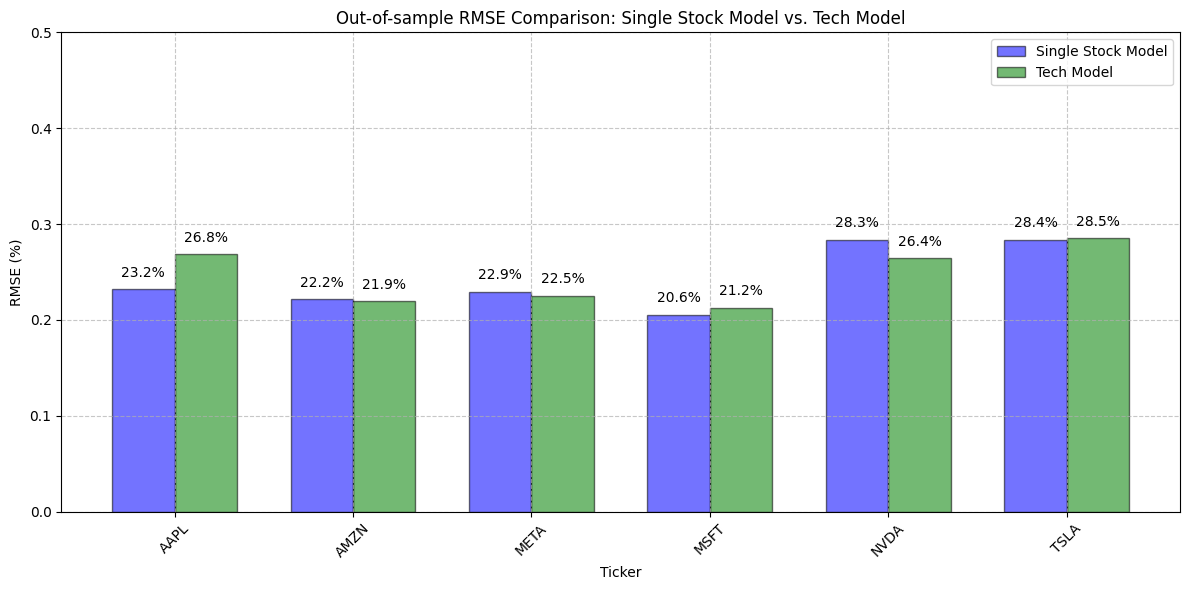

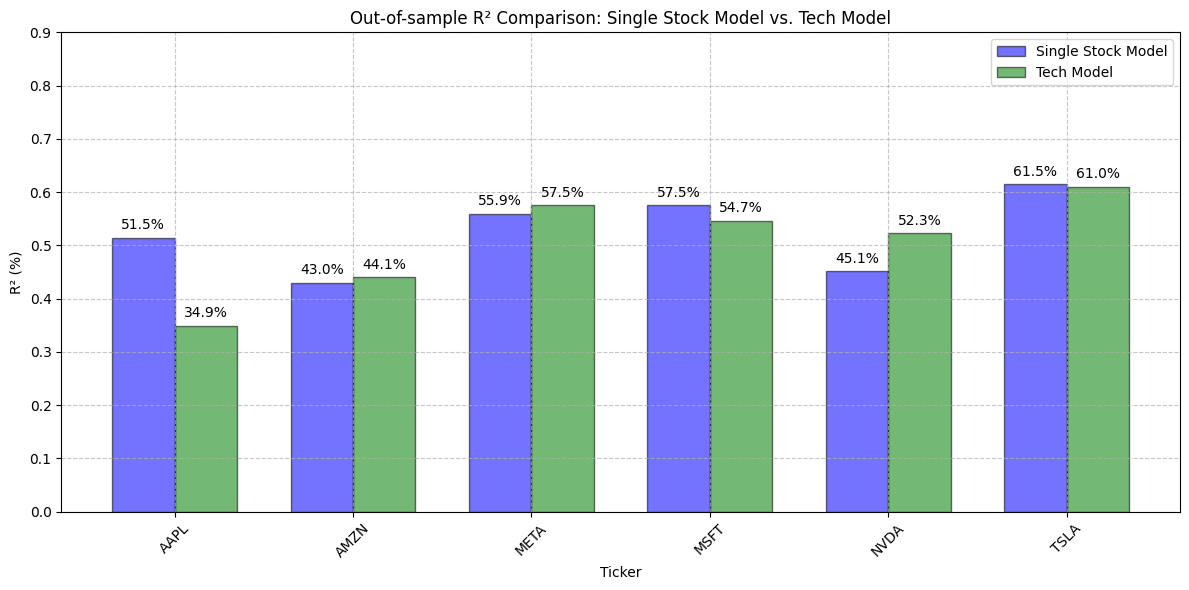

In [ ]:
# Convert lists to DataFrames for easier plotting
results_list_sso_df = pd.DataFrame(results_list_sso).set_index('Ticker').sort_index()
results_list_all_df = pd.DataFrame(results_list_all).set_index('Ticker').sort_index()

# Define the x locations for the groups and bar width
x = np.arange(len(results_list_sso_df.index))
width = 0.35  # Width of the bars

# Plot RMSE comparison
plt.figure(figsize=(12, 6))
bars_sso_rmse = plt.bar(x - width/2, results_list_sso_df['RMSE'], width=width, label='Single Stock Model', color='blue', alpha=0.55, edgecolor='black')
bars_all_rmse = plt.bar(x + width/2, results_list_all_df['RMSE'], width=width, label='Tech Model', color='green', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for RMSE (converted to percentage format)
for bar in bars_sso_rmse:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')
for bar in bars_all_rmse:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Ticker')
plt.ylabel('RMSE (%)')
plt.title('Out-of-sample RMSE Comparison: Single Stock Model vs. Tech Model')
plt.xticks(ticks=x, labels=results_list_sso_df.index, rotation=45)
plt.legend()
plt.ylim([0, 0.5])  # Adjusted for percentage scale
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot R² comparison
plt.figure(figsize=(12, 6))
bars_sso_r2 = plt.bar(x - width/2, results_list_sso_df['R²'], width=width, label='Single Stock Model', color='blue', alpha=0.55, edgecolor='black')
bars_all_r2 = plt.bar(x + width/2, results_list_all_df['R²'], width=width, label='Tech Model', color='green', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for R² (converted to percentage format)
for bar in bars_sso_r2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')
for bar in bars_all_r2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Ticker')
plt.ylabel('R² (%)')
plt.title('Out-of-sample R² Comparison: Single Stock Model vs. Tech Model')
plt.xticks(ticks=x, labels=results_list_sso_df.index, rotation=45)
plt.legend()
plt.ylim([0, 0.9])  # Adjusted for percentage scale
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
